# このノートブックについて

summary_ot2ypd-ot2ypdtm-humanypd-humanypdtm.csvのスポットアッセイの結果を可視化する。


In [344]:
import datetime

t_delta = datetime.timedelta(hours=9)  # 9時間
JST = datetime.timezone(t_delta, 'JST')  # UTCから9時間差の「JST」タイムゾーン
dt_now = datetime.datetime.now(JST)  # タイムゾーン付きでローカルな日付と時刻を取得

print(dt_now)

2022-06-25 00:47:47.590632+09:00


# 必要なライブラリのインストールと呼び出し


In [345]:
from plotnine import *
import pandas as pd
import numpy as np

%matplotlib inline

In [346]:
import statsmodels.api as sm
import os

# データの読み込み

In [347]:
target_dir = "/mnt/d/github_repo/automatic_spotassay/data_analysis"

In [348]:
dataframe = pd.read_csv(target_dir + "/summary_ot2ypd-ot2ypdtm-humanypd-humanypdtm.csv", index_col=0)

In [349]:
dataframe.head()

,Mean,executer,agar,timepoint,plate,serial_num,spot,normalized
0,77.206,ot2,YPD,1,1,1,1,1.0
1,76.971,ot2,YPD,1,1,1,2,1.0
2,76.995,ot2,YPD,1,1,1,3,1.0
3,77.085,ot2,YPD,1,1,1,4,1.0
4,77.370,ot2,YPD,1,1,1,5,1.0


In [350]:
dataframe.shape

(21600, 8)

# 加工

列を追加する

In [351]:
conditions = [
    (dataframe['serial_num'] == 1) | (dataframe['serial_num'] == 2) | (dataframe['serial_num'] == 3),
    (dataframe['serial_num'] == 4) | (dataframe['serial_num'] == 5) | (dataframe['serial_num'] == 6)
    ]
choices = ['0_WT', '1_MT']
dataframe['genotype'] = np.select(conditions, choices)

In [352]:
conditions = [
    (dataframe['plate'] == 1),
    (dataframe['plate'] == 2)
    ]
choices = ['Plate_1', 'Plate_2']
dataframe['Plate'] = np.select(conditions, choices)

# 可視化：それぞれのスポットの時系列を追う

横軸は `timepoint`

同じプロットの中に、同じ `spot` 同じ `genotype + agar` のデータが入る


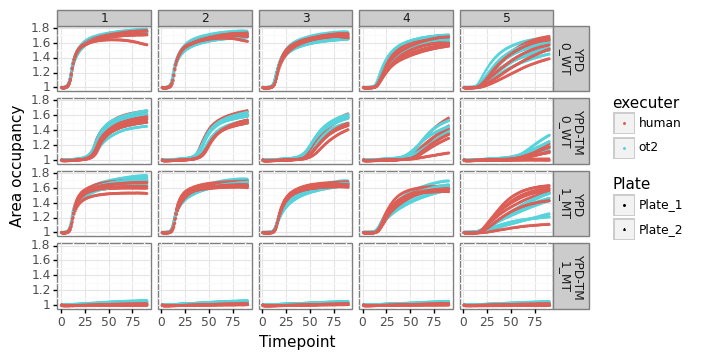

<ggplot: (8742659568327)>

In [364]:
# 例


plot = (
    ggplot(dataframe) 
    #+ geom_smooth(aes(x='factor(image)', y='Mean', color='executer', group='executer + Plate', linetype='Plate'), method='lm', size=0.4)
    + geom_point(aes(x='timepoint', y='normalized', color='executer', group='executer + Plate', shape='Plate'), size=0.2)
    + facet_grid('genotype + agar ~ spot')
    + theme_bw()
    + labs(x="Timepoint", y="Area occupancy" )
    + theme(aspect_ratio=0.7)
)

plot


# 傾きの時系列

In [392]:
def myfunc(data):
  Y = data['normalized']
  X = data['spot']
  X = sm.add_constant(X)
  model = sm.OLS(Y,X)
  results = model.fit()
  return results.params.spot, results.params.const, results.rsquared 

regression_coefs = dataframe.groupby(['timepoint', 'executer', 'genotype', 'agar', 'Plate']).apply(myfunc)

/home/tgc/anaconda3/envs/autospot/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars


In [393]:
df_regression_coefs = regression_coefs.to_frame().reset_index().rename(columns = {0: 'regression_result'})

df_regression_coefs[['regression_coef', 'regression_const', 'regression_R2']] = pd.DataFrame(df_regression_coefs['regression_result'].tolist(), index=df_regression_coefs.index)

df_regression_coefs

,timepoint,executer,genotype,agar,Plate,regression_result,regression_coef,regression_const,regression_R2
0,1,human,0_WT,YPD,Plate_1,"(-2.7755575615628914e-17, 1.0, -inf)",-2.775558e-17,1.000000,-inf
1,1,human,0_WT,YPD,Plate_2,"(-2.7755575615628914e-17, 1.0, -inf)",-2.775558e-17,1.000000,-inf
2,1,human,0_WT,YPD-TM,Plate_1,"(-2.7755575615628914e-17, 1.0, -inf)",-2.775558e-17,1.000000,-inf
3,1,human,0_WT,YPD-TM,Plate_2,"(-2.7755575615628914e-17, 1.0, -inf)",-2.775558e-17,1.000000,-inf
4,1,human,1_MT,YPD,Plate_1,"(-2.7755575615628914e-17, 1.0, -inf)",-2.775558e-17,1.000000,-inf
...,...,...,...,...,...,...,...,...,...
1435,90,ot2,0_WT,YPD-TM,Plate_2,"(-0.07898155905100443, 1.6499275033172407, 0.7...",-7.898156e-02,1.649928,0.754155
1436,90,ot2,1_MT,YPD,Plate_1,"(-0.06455186891971809, 1.7983294647054424, 0.5...",-6.455187e-02,1.798329,0.544740
1437,90,ot2,1_MT,YPD,Plate_2,"(-0.07533293451827983, 1.8573940223584717, 0.6...",-7.533293e-02,1.857394,0.639243
1438,90,ot2,1_MT,YPD-TM,Plate_1,"(-0.002786500264607361, 1.0447712173347796, 0....",-2.786500e-03,1.044771,0.075002


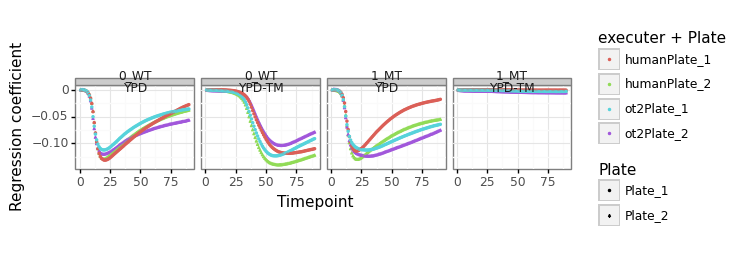

<ggplot: (8742661750519)>

In [394]:
# x: timepoint, y: regression_coef

plot = (
    ggplot(df_regression_coefs) 
    + geom_point(aes(x='timepoint', y='regression_coef', color='executer + Plate', group='executer + Plate', shape='Plate'), size=0.4)
    + facet_grid('. ~ genotype + agar')
    + theme_bw()
    + labs(x="Timepoint", y="Regression coefficient" )
    + theme(aspect_ratio=0.7)
#    + scale_y_log10() 
)

plot

# 論文用Figure の作業スペース

## ⭐️プロット関数の定義

In [456]:
import os

In [457]:
def line_plot_custom(df_tmp1, df_regression_coefs_tmp, outdir):
  y_max = np.max(df_tmp1['normalized'])

  plot = (
      ggplot(df_tmp1)
      + stat_smooth(aes(x='spot', y='normalized', color='executer', group='executer + Plate', linetype='Plate'), size=0.4, method="lm")
      + geom_point(aes(x='spot', y='normalized', color='executer', group='executer + Plate', shape='Plate'), size=0.4)
      + facet_grid('executer ~ agar + genotype', labeller=labeller(rows=row_func, cols=col_func))
      + geom_text(data=df_regression_coefs_tmp, mapping=aes(x=5, y='y_max*1.05+offset*0.02', label='regression_text'), ha='right', va='top', size=4) 
      + theme_bw()
      + labs(x="Dilution rate", y="Normalized area", title=caption_text)
      + scale_color_manual(breaks=['human', 'ot2'], labels=['Human', 'OT-2'], values=['#DC3220', '#005AB5'])
      + scale_linetype_discrete(breaks=['Plate_1', 'Plate_2'], labels=['Plate 1', 'Plate 2'])
      + scale_shape_discrete(breaks=['Plate_1', 'Plate_2'], labels=['Plate 1', 'Plate 2'])
      + theme(aspect_ratio=0.7)
      + theme(plot_title=element_text(size=10), axis_title=element_text(size=10),  axis_text=element_text(size=8),
              legend_text=element_text(size=10), legend_title=element_text(size=10), strip_background = element_blank(),
              panel_grid_minor=element_blank())
  )
  plot.save(os.path.join(outdir, 'Figure_3C.svg'))

  return plot

In [459]:
def cv_plot_custom(df_tmp2, outdir):
  # CV at a specfic timepoint

  # x: timepoint, y: regression_coef

  plot = (
      ggplot(df_tmp2) 
      + geom_line(aes(x='spot', y='cv_normalized', color='executer', group='executer + Plate', linetype='Plate'), size=0.4)
      + geom_point(aes(x='spot', y='cv_normalized', color='executer', group='executer + Plate'), size=0.4)
      + facet_grid('. ~ agar + genotype', labeller=labeller(rows=row_func, cols=col_func))
      + theme_bw()
      + labs(x="Dilution rate", y="CV of normalized area", title=caption_text)
      + scale_color_manual(breaks=['human', 'ot2'], labels=['Human', 'OT-2'], values=['#DC3220', '#005AB5'])
      + scale_linetype_discrete(breaks=['Plate_1', 'Plate_2'], labels=['Plate 1', 'Plate 2'])
      + scale_shape_discrete(breaks=['Plate_1', 'Plate_2'], labels=['Plate 1', 'Plate 2'])
      + theme(aspect_ratio=0.7)
      + theme(plot_title=element_text(size=10), axis_title=element_text(size=10),  axis_text=element_text(size=8),
              legend_text=element_text(size=10), legend_title=element_text(size=10), strip_background = element_blank(),
              panel_grid_minor=element_blank())
  )

  plot.save(os.path.join(outdir, 'Figure_3D.svg'))

  return plot

In [461]:
# OT-2
def row_func(s):
  if s == "ot2":
    return "OT-2"
  if s == "human":
    return "Human"
  else:
    return s

def col_func(s):
  x = s.replace("1_MT", "hac1Δ")
  x = x.replace("0_WT", "WT")
  x = x.replace("-TM", "+TM")
  return x

In [463]:
def configure_custom(timepoint_ypd, timepoint_ypdtm):

  # Outdir
  outdir = "/mnt/d/github_repo/automatic_spotassay/data_analysis/Figures_ypd%d_ypdtm%d" % (timepoint_ypd, timepoint_ypdtm)
  if not os.path.exists(outdir):
    os.makedirs(outdir)
  print('outdir:\n', outdir, '\n\n\n')

  df_tmp1 = dataframe.query('(agar=="YPD" and timepoint == @timepoint_ypd) or (agar=="YPD-TM" and timepoint == @timepoint_ypdtm)', engine='python')
  df_tmp2 = df_cv_normalized.query('(agar=="YPD" and timepoint == @timepoint_ypd) or (agar=="YPD-TM" and timepoint == @timepoint_ypdtm)', engine='python')

  df_regression_coefs_tmp = df_regression_coefs.query('(agar=="YPD" and timepoint == @timepoint_ypd) or (agar=="YPD-TM" and timepoint == @timepoint_ypdtm)')
  df_regression_coefs_tmp['regression_text'] = df_regression_coefs_tmp.apply(lambda row: '%s: y=%.2fx+%.2f (R2=%.2f)' % (row.Plate, row.regression_coef, row.regression_const, row.regression_R2), axis=1)
  df_regression_coefs_tmp['offset'] =  np.where(df_regression_coefs_tmp['Plate'] == 'Plate_1', 0, -2)

  caption_text = "YPD: %d hr, YPD+TM: %d hr" % (timepoint_ypd * 1.5, timepoint_ypdtm * 1.5)
  print(caption_text)


  # Head
  print(df_regression_coefs_tmp.head())


  # Save data

  df_tmp1.to_csv(os.path.join(outdir, 'Figure_3C_normalized_area.tsv'), sep='\t')

  df_regression_coefs_tmp.to_csv(os.path.join(outdir, 'Figure_3C_regression_coefficient.tsv'), sep='\t')

  df_tmp2.to_csv(os.path.join(outdir, 'Figure_3D_CV.tsv'), sep='\t')

  return df_tmp1, df_tmp2, df_regression_coefs_tmp, outdir, caption_text

## ⭐️Config (timepoint_ypd = 20, timepoint_ypdtm = 60)

In [469]:
timepoint_ypd = 20
timepoint_ypdtm = 60

df_tmp1, df_tmp2, df_regression_coefs_tmp, outdir, caption_text = configure_custom(timepoint_ypd, timepoint_ypdtm)

import datetime
t_delta = datetime.timedelta(hours=9)  # 9時間
JST = datetime.timezone(t_delta, 'JST')  # UTCから9時間差の「JST」タイムゾーン
dt_now = datetime.datetime.now(JST)  # タイムゾーン付きでローカルな日付と時刻を取得
print(dt_now)

outdir:
 /mnt/d/github_repo/automatic_spotassay/data_analysis/Figures_ypd20_ypdtm60 



YPD: 30 hr, YPD+TM: 90 hr
     timepoint executer genotype agar    Plate  \
304         20    human     0_WT  YPD  Plate_1   
305         20    human     0_WT  YPD  Plate_2   
308         20    human     1_MT  YPD  Plate_1   
309         20    human     1_MT  YPD  Plate_2   
312         20      ot2     0_WT  YPD  Plate_1   

                                     regression_result  regression_coef  \
304  (-0.13158078336926496, 1.6993279111501134, 0.9...        -0.131581   
305  (-0.12931223581400014, 1.7035858921671692, 0.9...        -0.129312   
308  (-0.11455354768633962, 1.6028667273062753, 0.9...        -0.114554   
309  (-0.12910211493675489, 1.6725990786738694, 0.9...        -0.129102   
312  (-0.11265756900823651, 1.6513802768153725, 0.9...        -0.112658   

     regression_const  regression_R2                   regression_text  offset  
304          1.699328       0.952611  Plate_1: y=-0.1

/tmp/ipykernel_10037/1770190621.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_10037/1770190621.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### 線グラフ・回帰直線

/home/tgc/anaconda3/envs/autospot/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/tgc/anaconda3/envs/autospot/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /mnt/d/github_repo/automatic_spotassay/data_analysis/Figures_ypd20_ypdtm60/Figure_3C.svg


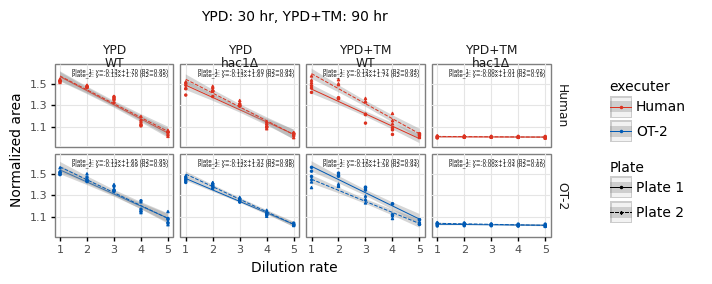

<ggplot: (8742663972118)>

In [470]:
plot = line_plot_custom(df_tmp1, df_regression_coefs_tmp, outdir)
plot

### CVのグラフ

/home/tgc/anaconda3/envs/autospot/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/tgc/anaconda3/envs/autospot/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /mnt/d/github_repo/automatic_spotassay/data_analysis/Figures_ypd20_ypdtm60/Figure_3D.svg
/home/tgc/anaconda3/envs/autospot/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'shape' aesthetic. Make sure you have mapped a variable to it
/home/tgc/anaconda3/envs/autospot/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'shape' aesthetic. Make sure you have mapped a variable to it


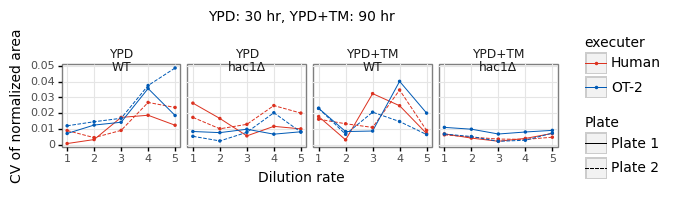

<ggplot: (8742664553482)>

In [471]:
plot = cv_plot_custom(df_tmp2, outdir)
plot